In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Reshape
from keras.layers import Convolution2D, Convolution3D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import pescador

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

Using Theano backend.


# load data

In [2]:
def sum_to_prob(sum_array):
    sum_shift = sum_array + 1.0
    total = np.sum(sum_shift)
    return sum_shift/total

In [3]:
def normalize_data(input_cqt):
    norm_data = input_cqt - np.min(input_cqt)
    norm_data = norm_data / np.max(norm_data)
    return norm_data

In [4]:
def __grab_patch_input(f, t, n_f, n_t, n_harms, x_data):
    return np.transpose(
        x_data[:, f: f + n_f, t: t + n_t], (1, 2, 0)).reshape(1, n_f, n_t, n_harms)

In [5]:
def __grab_patch_output(f, t, n_f, n_t, y_data):
    return y_data[f: f + n_f, t: t + n_t].reshape(1, n_f, n_t)

In [6]:
def patch_generator(input_cqt, pitch_activation_map, patch_size=(20, 20)):
    norm_data = normalize_data(input_cqt)

    n_harms, n_freqs, n_times = norm_data.shape
    n_f, n_t = patch_size

    f_indices = np.arange(0, n_freqs - n_f)
    t_indices = np.arange(0, n_times - n_t)
    f_dist = sum_to_prob(pitch_activation_map[:-n_f, :].sum(axis=1))
    t_dist = sum_to_prob(pitch_activation_map[:, :-n_t].sum(axis=0))

    while True:
        f = np.random.choice(f_indices, p=f_dist)
        t = np.random.choice(t_indices, p=t_dist)
        x = __grab_patch_input(f, t, n_f, n_t, n_harms, norm_data)
        y = __grab_patch_output(f, t, n_f, n_t, pitch_activation_map)
        yield dict(X=x, Y=y)

In [7]:
def stride_cqt(input_cqt, patch_size=(20, 20)):
    norm_data = normalize_data(input_cqt)

    n_harms, n_freqs, n_times = norm_data.shape
    n_f, n_t = patch_size

    f_indices = np.arange(0, n_freqs - n_f, n_f/2)
    t_indices = np.arange(0, n_times - n_t, n_t/2)
    for f in f_indices:
        for t in t_indices:
            x = __grab_patch_input(f, t, n_f, n_t, n_harms, norm_data)
            yield(dict(X=x, t=t, f=f))

In [8]:
def keras_generator(data_list, patch_size=(20, 20), n_samples=10000,
                    n_active=1000, with_replacement=False, batch_size=1024):
    streams = []
    for data_in, data_out in data_list:
        streams.append(
            pescador.Streamer(
                patch_generator, data_in, data_out, patch_size=patch_size
            )
        )
    
    stream_mux = pescador.Mux(streams, 2,
        with_replacement=True, lam=None
    )

    batch_generator = pescador.buffer_batch(stream_mux.generate(), batch_size)

    for batch in batch_generator:
        yield (batch['X'], batch['Y'])

In [9]:
data_files = glob.glob(os.path.join("../output/training_data/*.npz"))

print(len(data_files))

0


In [ ]:
data = [np.load(fpath, mmap_mode='r') for fpath in data_files][:16]
data_list = [
    [d['data_in'], d['data_out']] for d in data
]

train_samples = int(np.round(len(data_files) * 0.8))

In [ ]:
train_generator = keras_generator(data_list[:train_samples])
validation_generator = keras_generator(data_list[train_samples:])

# Build Model

In [13]:
input_shape = (26, 26, 6)
inputs = Input(shape=input_shape)

y1 = Convolution2D(
    256, 3, 3, border_mode='valid', activation='relu', name='bendy'
)(inputs)
y2 = Convolution2D(
    128, 3, 3, border_mode='valid', activation='relu', name='smoothy1'
)(y1)
y3 = Convolution2D(
    64, 3, 3, border_mode='valid', activation='relu', name='smoothy2'
)(y2)
y4 = Convolution2D(
    1, 1, 1, border_mode='valid', activation='sigmoid', name='squishy'
)(y3)
predictions = Reshape((20, 20), name='reshapeeee')(y4)

model = Model(input=inputs, output=predictions)

# Compile Model

In [16]:
# loss binary cross entropy
model.compile(loss='kld',
              optimizer='sgd')

In [15]:
model.compile?

In [14]:
model.summary(line_length=103)

_______________________________________________________________________________________________________
Layer (type)                     Output Shape           Param #      Connected to                      
input_8 (InputLayer)             (None, 26, 26, 6)      0                                              
_______________________________________________________________________________________________________
bendy (Convolution2D)            (None, 24, 24, 256)    14080        input_8[0][0]                     
_______________________________________________________________________________________________________
smoothy1 (Convolution2D)         (None, 22, 22, 128)    295040       bendy[0][0]                       
_______________________________________________________________________________________________________
smoothy2 (Convolution2D)         (None, 20, 20, 64)     73792        smoothy1[0][0]                    
________________________________________________________________

# Fit Model

In [17]:
samples_per_epoch = 1024 * 100
nb_epochs = 10
nb_val_samples = 1024

history = model.fit_generator(
    train_generator, samples_per_epoch, nb_epochs, verbose=1,
    validation_data=validation_generator, nb_val_samples=nb_val_samples
)

NameError: name 'train_generator' is not defined

In [ ]:
# plot filters
conv_layer = model.get_layer(name='bendy')
weights = conv_layer.get_weights()
weight_array = weights[0]
plt.figure(figsize=(15, 15))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(weight_array[:, :, 0, i], origin='lower')
    plt.axis('square')

plt.show()

In [ ]:
# plot filters
conv_layer = model.get_layer(name='smoothy')
weights = conv_layer.get_weights()
weight_array = weights[0]
plt.figure(figsize=(15, 15))
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(weight_array[:, :, 0, i], origin='lower')
    plt.axis('square')

plt.show()

In [ ]:
def plot_stuff(X, Y, Y_pred):
    sns.set_style('white')
    plt.figure(figsize=(15, 15))
    
    plt.subplot(3, 1, 1)
    plt.title("prediction")
    plt.imshow(Y_pred[0], origin='lower', cmap='hot', vmin=0, vmax=1)
    plt.axis('auto')
#     plt.xlim(a, b)
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.title('target')
    plt.imshow(Y[0], origin='lower', cmap='hot', vmin=0, vmax=1)
    plt.axis('auto')
#     plt.xlim(a, b)
    plt.colorbar()

    plt.subplot(3, 1, 3)
    plt.title('input')
    plt.imshow(X[0, :, :, 0], origin='lower', cmap='hot', vmin=0, vmax=1)
    plt.axis('auto')
#     plt.xlim(a, b)
    plt.colorbar()
    plt.show()

In [ ]:
for X, Y in validation_generator:
    Y_pred = model.predict(X)
    plot_stuff(X, Y, Y_pred)
    break
    if np.sum(Y[0].flatten()) > 0:
        plot_stuff(X, Y, Y_pred)
        break

In [ ]:
for X, Y in train_generator:
    for x, y in zip(X, Y):
        if np.sum(y.flatten()) > 0:
            plt.figure(figsize=(15, 15))
            plt.subplot(2, 1, 1)
            plt.imshow(x[:, :, 0], origin='lower', cmap='hot')
            plt.axis('square')

            plt.subplot(2, 1, 2)
            plt.imshow(y, origin='lower', cmap='hot')
            plt.axis('square')
            break

# Evaluate Model

In [ ]:
model.count_params()

In [ ]:
OLAP_KERNEL = np.zeros((20, 20))
for i in range(11):
    for j in range(11):
        val = 0.1*float(i)*0.1*float(j)
        OLAP_KERNEL[i, j] = val
        OLAP_KERNEL[-i, j] = val
        OLAP_KERNEL[i, -j] = val
        OLAP_KERNEL[-i, -j] = val

In [ ]:
def get_full_track_prediction(data_in, model):

    n_harms, n_freqs, n_times = data_in.shape
    n_f, n_t = (20, 20)

    prediction = np.zeros((n_freqs, n_times))

    cqt_patch_generator = stride_cqt(data_in)

    for d in cqt_patch_generator:
        f = d['f']
        t = d['t']
        y_pred = model.predict(d['X'].reshape(1, n_f, n_t, n_harms)).reshape(n_f, n_t)
#         prediction[f: f + n_f, t: t + n_t] += y_pred * OLAP_KERNEL
        prediction[f: f + n_f, t: t + n_t] = y_pred

    return prediction
    

In [ ]:
test_prediction = get_full_track_prediction(dat3['data_in'], model)

In [ ]:
a, b = (10000, 20000)

sns.set_style('white')
plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.imshow(test_prediction**10, origin='lower', cmap='hot')
# plt.imshow((1.0 - test_prediction)**1000, origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(a, b)
# plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(dat3['data_out'], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(a, b)

plt.subplot(3, 1, 3)
plt.imshow(dat3['data_in'][0, :, :], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(a, b)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.imshow(dat3['data_in'][0], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(0, 10000)

In [ ]:
plt.imshow(dat3['data_out'], origin='lower', cmap='hot')
plt.axis('auto')
plt.xlim(0, 10000)

In [1]:
import numpy as np

In [60]:
test = np.zeros((100, 100))

In [61]:
for i in range(50):
    test[i, i] = 1
for j in range(50, 100):
    test[50, j] = 1

In [62]:
test

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 99.5, -0.5, 99.5)

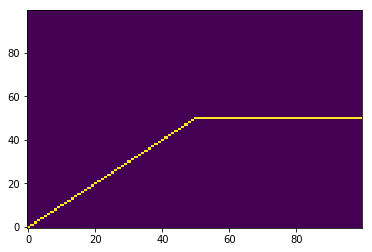

In [63]:
plt.imshow(test, origin='lower', interpolation='none')
plt.axis('auto')

In [13]:
from scipy.ndimage import filters

In [76]:
test_filt = filters.gaussian_filter1d(test, 2, axis=0, mode='constant')
test_filt = test_filt/np.max(test_filt)

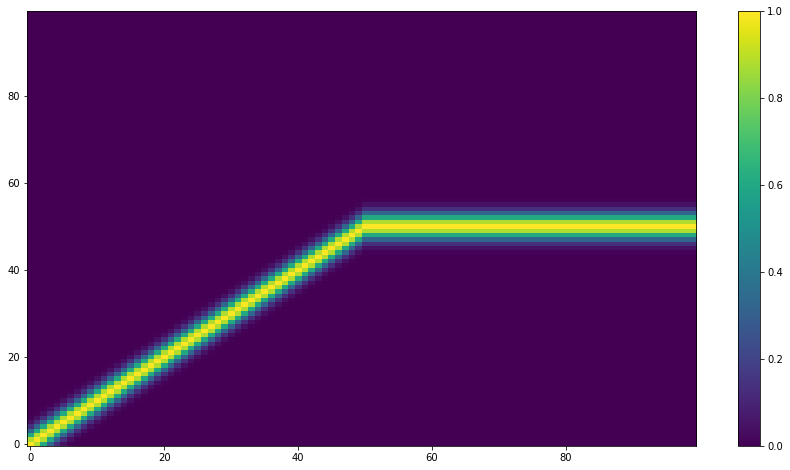

In [77]:
plt.figure(figsize=(15, 8))
plt.imshow(test_filt, origin='lower', interpolation='none')
plt.axis('auto')
plt.colorbar()